In [1]:
from collections import defaultdict
from json import dumps
import os, urllib.request
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datasets
import transformers
import torch
import tqdm

from projection_simplex_vectorized import projection_simplex
import postprocess

model_name = "bert-base-uncased"
model_dir = "models/biasbios_squared_loss"

n_epochs = 3
batch_size = 32
lr = 2e-5
warmup_ratio = 0.1
weight_decay = 0.01
max_grad_norm = 1.0

split_ratio_for_postprocessing = 0.05

seed = 33
transformers.set_seed(seed)
rng = np.random.default_rng(seed)
noise_fn = lambda shape: rng.laplace(loc=0.0, scale=0.2 / 28, size=shape)
n_perturbations = 10

device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

## Download and load BiasBios dataset

In [2]:
label_names = [
    "accountant", "architect", "attorney", "chiropractor", "comedian",
    "composer", "dentist", "dietitian", "dj", "filmmaker", "interior_designer",
    "journalist", "model", "nurse", "painter", "paralegal", "pastor",
    "personal_trainer", "photographer", "physician", "poet", "professor",
    "psychologist", "rapper", "software_engineer", "surgeon", "teacher",
    "yoga_teacher"
]
n_labels = len(label_names)

group_names = ["female", "male"]
n_groups = len(group_names)

features = datasets.Features({
    "bio": datasets.Value("string"),
    "title": datasets.ClassLabel(names=label_names),
    "gender": datasets.ClassLabel(names=group_names),
})

train_path = "data/biasbios/train.pickle"
test_path = "data/biasbios/test.pickle"
dev_path = "data/biasbios/dev.pickle"
if any([not os.path.exists(p) for p in [train_path, test_path, dev_path]]):
  os.makedirs("data/biasbios", exist_ok=True)
  urllib.request.urlretrieve(
      "https://storage.googleapis.com/ai2i/nullspace/biasbios/train.pickle",
      train_path)
  urllib.request.urlretrieve(
      "https://storage.googleapis.com/ai2i/nullspace/biasbios/test.pickle",
      test_path)
  urllib.request.urlretrieve(
      "https://storage.googleapis.com/ai2i/nullspace/biasbios/dev.pickle",
      dev_path)

raw_dataset = {}
for split, path in zip(["train", "test", "dev"],
                       [train_path, test_path, dev_path]):
  rows = {k: [] for k in features}
  with open(path, "rb") as pickle_file:
    for row in pickle.load(pickle_file):
      rows["gender"].append("female" if row["g"] == "f" else "male")
      rows["title"].append(row["p"])
      rows["bio"].append(rows["gender"][-1] + ". " +
                         row["hard_text_untokenized"])
  raw_dataset[split] = datasets.Dataset.from_dict(rows, features=features)
raw_dataset = datasets.DatasetDict(raw_dataset)

print(dumps(raw_dataset["train"][0], indent=2))

{
  "bio": "female. She has been working with children in camp, community and school settings for the past 8 years. She believes in the importance of cultivating self-love and awareness in black children at a very young age and is excited to be apart of Black Lives Matter Toronto\u2019s Freedom School!",
  "title": 26,
  "gender": 0
}


In [3]:
# Compute and print dataset statistics

df = datasets.concatenate_datasets([d for d in raw_dataset.values()])
df = pd.DataFrame(np.stack(
    [np.array(group_names)[df["gender"]],
     np.array(label_names)[df["title"]]],
    axis=1),
                  columns=["Group", "Target"])
grouped = df.groupby(["Target", "Group"]).size().unstack()
n_labels = len(grouped.index)
n_groups = len(grouped.columns)
counts = grouped.sum(axis=0)
normalized = np.nan_to_num((grouped.to_numpy() / counts.to_numpy())).T
diff = np.abs(normalized[:, None, :] - normalized[None, :, :])
postprocessor = postprocess.PostProcessorDP()
postprocessor.fit(np.concatenate([np.eye(n_labels) for _ in range(n_groups)],
                                 axis=0),
                  np.repeat(np.arange(n_groups), n_labels),
                  p=normalized.flatten())
res = {
    "balanced_accuracy": {
        "perfect_postprocessed": (n_groups - postprocessor.score_) / n_groups
    },
    "dp_gap_linf_max": {
        "perfect_predictor": np.max(diff)
    },
    "dp_gap_l1_max": {
        "perfect_predictor": np.max(1 / 2 * np.sum(diff, axis=2))
    },
    "dp_gap_l1_avg": {
        "perfect_predictor":
            np.mean(1 / 2 * np.sum(diff, axis=2)[np.triu_indices(n_groups, 1)])
    },
}

display(pd.DataFrame(res))
display(grouped / counts)
display(pd.DataFrame(counts, columns=["Count"]).T)

,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
perfect_postprocessed,0.884376,NaN,NaN,NaN
perfect_predictor,NaN,0.08644,0.231247,0.231247


Group,female,male
Target,,
accountant,0.011428,0.016898
architect,0.013168,0.036508
attorney,0.068610,0.095177
chiropractor,0.003789,0.009029
comedian,0.003251,0.010444
composer,0.005041,0.022156
dentist,0.028297,0.044132
dietitian,0.020258,0.001368
dj,0.001159,0.006029


Group,female,male
Count,182102,211321


### Tokenize BiasBios dataset

In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
  tokenized_examples = tokenizer(examples["bio"],
                                 padding=False,
                                 max_length=tokenizer.model_max_length,
                                 truncation=True)
  tokenized_examples["labels"] = examples["title"]
  tokenized_examples["group_labels"] = examples["gender"]
  return tokenized_examples


tokenized_dataset = raw_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=raw_dataset["train"].column_names,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/256 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/99 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/40 [00:00<?, ?ba/s]

In [5]:
# Train data split
split_dataset = tokenized_dataset["train"].train_test_split(
    test_size=split_ratio_for_postprocessing, seed=seed)
train_dataset_predictor = split_dataset["train"]
train_dataset_postprocessor = split_dataset["test"]
eval_dataset = tokenized_dataset["test"]
dev_dataset = tokenized_dataset["dev"]

data_collator = transformers.DataCollatorWithPadding(tokenizer)
train_dataloader_predictor = torch.utils.data.DataLoader(
    train_dataset_predictor,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size)
train_dataloader_postprocessor = torch.utils.data.DataLoader(
    train_dataset_postprocessor,
    collate_fn=data_collator,
    batch_size=batch_size)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset,
                                              collate_fn=data_collator,
                                              batch_size=batch_size)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset,
                                             collate_fn=data_collator,
                                             batch_size=batch_size)

## Load/train NLU model

In [6]:
model = None
is_finetuned = False
if os.path.exists(model_dir):
  model = transformers.AutoModelForSequenceClassification.from_pretrained(
      model_dir).to(device)
  is_finetuned = True
else:
  model = transformers.AutoModelForSequenceClassification.from_pretrained(
      model_name, num_labels=n_labels).to(device)

model_input_args = list(model.forward.__code__.co_varnames)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
if not is_finetuned:
  no_decay = ["bias", "LayerNorm.weight"]
  optimizer_grouped_parameters = [
      {
          "params": [
              p for n, p in model.named_parameters()
              if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": weight_decay,
      },
      {
          "params": [
              p for n, p in model.named_parameters()
              if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0
      },
  ]
  optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=lr)
  lr_scheduler = transformers.get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=(warmup_ratio * n_epochs *
                        len(train_dataloader_predictor)),
      num_training_steps=n_epochs * len(train_dataloader_predictor))

  loss_fn = torch.nn.MSELoss()
  metric = datasets.load_metric("accuracy")

  for epoch in range(n_epochs):
    model.train()
    for batch in tqdm.tqdm(train_dataloader_predictor,
                           desc=f"Train epoch {epoch}"):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      outputs = model(**batch)
      labels_one_hot = torch.nn.functional.one_hot(batch["labels"], n_labels)
      loss = loss_fn(outputs.logits, labels_one_hot.float())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
    model.eval()

    for batch in tqdm.tqdm(dev_dataloader, desc=f"Dev epoch {epoch}"):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      with torch.no_grad():
        outputs = model(**batch)
        probas = outputs.logits
        predictions = torch.argmax(probas, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
    print(f"epoch {epoch}: {dumps(metric.compute(), indent=2)}")

  model.save_pretrained(model_dir)

Dev epoch 0: 100%|██████████████████████████| 1231/1231 [00:59<00:00, 20.57it/s]


epoch 0: {
  "accuracy": 0.8431253016332647
}


Dev epoch 1: 100%|██████████████████████████| 1231/1231 [00:59<00:00, 20.61it/s]


epoch 1: {
  "accuracy": 0.8487134547486601
}


Dev epoch 2: 100%|██████████████████████████| 1231/1231 [00:59<00:00, 20.57it/s]


epoch 2: {
  "accuracy": 0.8527521654093322
}


## Post-process

In [8]:
def predict_fn(dataloader):
  model.eval()
  probas = []
  with torch.no_grad():
    for batch in tqdm.tqdm(dataloader, desc="Inference"):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      outputs = model(**batch)
      probas.append(projection_simplex(outputs.logits.cpu().numpy(), axis=1))
  return np.concatenate(probas, axis=0)


train_probas = predict_fn(train_dataloader_postprocessor)
eval_probas = predict_fn(eval_dataloader)

Inference: 100%|████████████████████████████| 3074/3074 [02:38<00:00, 19.37it/s]


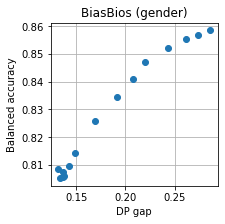

,accuracy,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
inf,0.857643,0.858578,0.105169,0.286506,0.286506
0.2,0.856066,0.856968,0.109022,0.274054,0.274054
0.18,0.854531,0.855396,0.112081,0.261364,0.261364
0.15,0.851196,0.852030,0.115217,0.243030,0.243030
0.12,0.846101,0.847008,0.115419,0.220124,0.220124
0.1,0.840021,0.841033,0.115087,0.207889,0.207889
0.08,0.833411,0.834588,0.115422,0.191708,0.191708
0.05,0.824575,0.825976,0.115289,0.168999,0.168999
0.02,0.812434,0.814107,0.115053,0.148953,0.148953
0.01,0.807990,0.809733,0.114680,0.142322,0.142322


In [9]:
eps = [
    0.2, 0.18, 0.15, 0.12, 0.1, 0.08, 0.05, 0.02, 0.01, 0.008, 0.005, 0.002,
    0.001, 0.0
]
res = defaultdict(dict)

for e in eps:
  postprocessor = postprocess.postprocess(
      lambda x: x,
      train_probas,
      np.array(train_dataset_postprocessor["group_labels"]),
      eps=e)
  r = postprocess.evaluate(lambda x: x, postprocessor, eval_probas,
                           np.array(eval_dataset["labels"]),
                           np.array(eval_dataset["group_labels"]), n_labels,
                           n_groups)
  for k, v in r.items():
    res[k]["inf"] = v["predictor"]
    res[k][e] = v["postprocessor"]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(res["dp_gap_l1_max"].values(),
           res["balanced_accuracy"].values(),
           zorder=2)
ax.set_xlabel("DP gap")
ax.set_ylabel("Balanced accuracy")
ax.set_title("BiasBios (gender)")
ax.grid(True, which="both", zorder=0)
plt.show()
display(pd.DataFrame(res))

In [10]:
postprocessor = postprocess.postprocess(
    lambda x: x,
    train_probas,
    np.array(train_dataset_postprocessor["group_labels"]),
    noise_fn=noise_fn,
    n_perturbations=n_perturbations)
r = postprocess.evaluate(lambda x: x,
                         postprocessor,
                         eval_probas,
                         np.array(eval_dataset["labels"]),
                         np.array(eval_dataset["group_labels"]),
                         n_labels,
                         n_groups,
                         noise_fn=noise_fn,
                         n_perturbations=1000)
res = {
    k: {
        "inf": v["predictor"],
        0.0: v["postprocessor"]
    } for k, v in r.items()
}
print("With Laplace smoothing:")
display(pd.DataFrame(res))

With Laplace smoothing:


,accuracy,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
inf,0.857607,0.858546,0.105157,0.286606,0.286606
0.0,0.802047,0.803923,0.114706,0.123945,0.123945
